<a href="https://colab.research.google.com/github/ferhat00/LLM/blob/main/VIX_Dynamic_Hedging_Calculation_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas matplotlib scipy dataclasses typing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=719edca570b9cc81f9797549c24cbdf583cd025c035346b152b54ffad4340c05
  Stored in directory: /root/.cache/pip/wheels/12/98/52/2bffe242a9a487f00886e43b8ed8dac46456702e11a0d6abef
Successfully built typing


NASSIM TALEB HEDGING STRATEGIES: COMPREHENSIVE COMPARISON

Portfolio: £100,000 | Current VIX: 21.66
Objective: Hedge against 20% portfolio drawdown


TABLE 1: STRATEGY OVERVIEW
                         Strategy Taleb Rating                     Annual Cost                  Max Loss              Max Gain                                              Best For
         Long OTM Calls (Barbell)        ⭐⭐⭐⭐⭐                            £646                      £161             Unlimited                                True tail risk hedging
              Call Spread (25/40)          ⭐⭐⭐                           £1575                      £394           5511.811024           Moderate protection with budget constraints
          Ratio Call Spread (1x2)           ⭐⭐                            £378 Unlimited above breakeven       £2362 at VIX=35 AVOID for tail hedging - opposite of Taleb philosophy
      Calendar Spread (30 strike)         ⭐⭐⭐⭐                            £252                     

/tmp/ipython-input-1542927353.py:490: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1542927353.py:566: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.savefig('taleb_strategies_comparison.png', dpi=300, bbox_inches='tight')


✓ Saved: 'taleb_strategies_comparison.png'


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


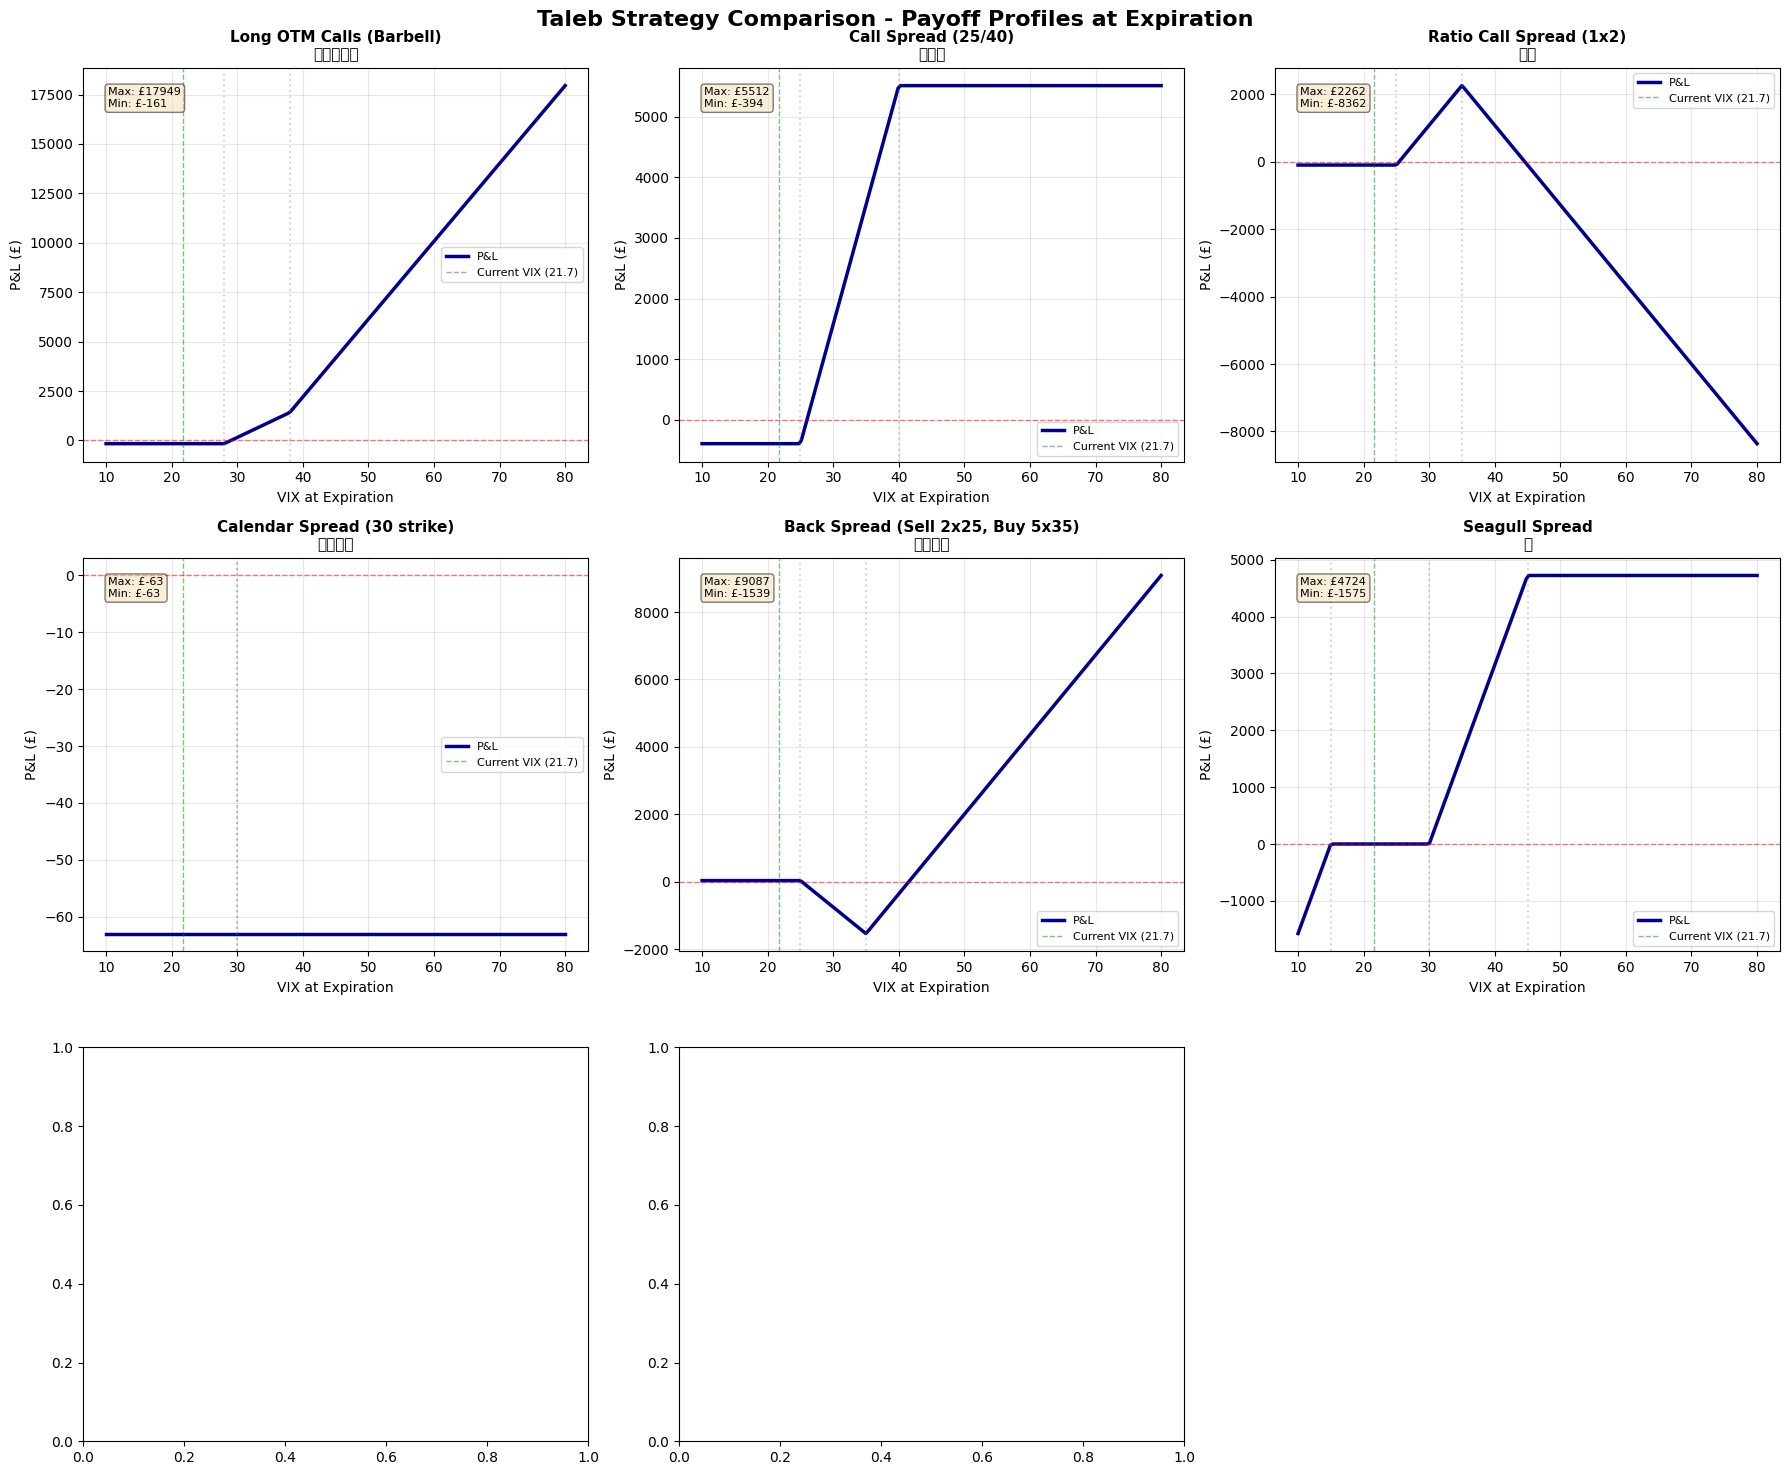



🎯 TALEB'S RECOMMENDATIONS - RANKED

1. ⭐⭐⭐⭐⭐ LONG OTM CALLS (BARBELL)
   → THE GOLD STANDARD for tail hedging
   → 2x Strike 28 + 3x Strike 38 = £489/quarter
   → Pure antifragility: benefits from convexity + vol-of-vol

   ✅ IMPLEMENT THIS

2. ⭐⭐⭐⭐ SPY PUT OPTIONS
   → Direct portfolio protection
   → Better correlation to your portfolio than VIX
   → 3x $500 strikes (10% OTM) = £667/quarter

   ✅ SOLID ALTERNATIVE if you want simplicity

3. ⭐⭐⭐⭐ CALENDAR SPREAD
   → Use short-term theta to finance long-term gamma
   → Net cost: £63/quarter (70% cheaper!)

   ✅ FOR SOPHISTICATED TRADERS

4. ⭐⭐⭐⭐ BACK SPREAD
   → Explosive upside if VIX > 35
   → Near zero cost

   ⚠️ ONLY IF convinced crash will be SEVERE

5. ⭐⭐⭐ CALL SPREAD
   → Cheaper but capped upside

   ⚠️ ACCEPTABLE but not optimal

6. ⭐⭐ VIX FUTURES & RATIO SPREAD
   → Various issues

   ❌ AVOID for tail hedging

7. ⭐ SEAGULL SPREAD
   → Contradicts Taleb principles

   ❌ NEVER USE
    

✓ Analysis complete!


In [1]:
"""
Building a Taleb-Inspired Portfolio Hedge: A Computational Approach to Tail Risk Protection
Complete implementation of the hedging strategy comparison framework
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from dataclasses import dataclass
from typing import List, Dict

@dataclass
class OptionLeg:
    """Represents a single option leg"""
    strike: float      # Strike price of the option
    premium: float     # Premium paid (or received if negative)
    quantity: int      # positive = long, negative = short
    option_type: str   # 'call' or 'put'


class TalebStrategyComparator:
    """
    Compare various Taleb-inspired hedging strategies:
    1. Long OTM Calls (Barbell)
    2. Call Spreads (Defined Risk)
    3. Ratio Spreads (Free Convexity)
    4. Calendar Spreads (Theta Financing)
    5. Back Spreads (Explosive Upside)
    6. VIX Futures vs Options
    7. Put Protection (Direct Equity Hedge)
    8. Seagull Spreads (Zero-Cost Collar)
    """

    def __init__(self, portfolio_value=100000, fx_rate=1.27):
        self.portfolio_value = portfolio_value  # Portfolio size in GBP
        self.fx_rate = fx_rate                  # USD to GBP conversion
        self.vix_multiplier = 100               # VIX contract multiplier
        self.current_vix = 21.66                # Current VIX spot level

    # ========================================================================
    # OPTION PRICING AND GREEKS
    # ========================================================================

    def calculate_greeks(self, S, K, T, r, sigma, option_type='call'):
        """Calculate all Greeks for an option position"""
        # Calculate d1 and d2 from Black-Scholes formula
        d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)

        # Price and delta depend on option type
        if option_type == 'call':
            price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
            delta = norm.cdf(d1)
        else:
            price = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
            delta = norm.cdf(d1) - 1

        # Gamma is the same for calls and puts (convexity!)
        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))

        # Vega: sensitivity to volatility changes
        vega = S * norm.pdf(d1) * np.sqrt(T) / 100

        # Theta: time decay (the cost of holding the position)
        theta = -(S*norm.pdf(d1)*sigma)/(2*np.sqrt(T)) - r*K*np.exp(-r*T)*norm.cdf(d2)
        theta = theta / 365  # Convert to daily theta

        return {
            'price': price,
            'delta': delta,
            'gamma': gamma,  # This is what Taleb cares about most!
            'vega': vega,
            'theta': theta
        }

    def calculate_strategy_payoff(self, legs: List[OptionLeg], vix_range: np.ndarray) -> np.ndarray:
        """Calculate payoff for multi-leg strategy across a range of VIX levels"""
        total_payoff = np.zeros_like(vix_range, dtype=float) # Initialize with float dtype

        for leg in legs:
            # Calculate intrinsic value at expiration for each VIX level
            if leg.option_type == 'call':
                intrinsic = np.maximum(0, vix_range - leg.strike)
            else:  # put
                intrinsic = np.maximum(0, leg.strike - vix_range)

            # Payoff = (intrinsic value - premium paid) * quantity * multiplier
            leg_payoff = (intrinsic - leg.premium) * leg.quantity
            total_payoff += leg_payoff

        # Convert to GBP for final display
        return total_payoff * self.vix_multiplier / self.fx_rate

    # ========================================================================
    # STRATEGY DEFINITIONS
    # ========================================================================

    def strategy_long_otm_calls(self):
        """
        Pure long OTM calls - Maximum convexity
        Taleb: "The most antifragile structure"
        """
        # Barbell structure: some near-the-money for moderate spikes,
        # more far-OTM for extreme tail events
        legs = [
            OptionLeg(strike=28, premium=0.65, quantity=2, option_type='call'),
            OptionLeg(strike=38, premium=0.25, quantity=3, option_type='call')
        ]

        # Calculate total cost per quarter
        cost_per_quarter = sum(leg.premium * abs(leg.quantity) for leg in legs) * self.vix_multiplier / self.fx_rate

        return {
            'name': 'Long OTM Calls (Barbell)',
            'legs': legs,
            'cost_per_quarter': cost_per_quarter,
            'annual_cost': cost_per_quarter * 4,
            'max_loss': cost_per_quarter,  # Can only lose what you paid
            'max_gain': 'Unlimited',        # No cap on upside
            'taleb_rating': '⭐⭐⭐⭐⭐',
            'description': "Pure convexity. Taleb's favorite. Maximum antifragility.",
            'pros': ['Unlimited upside', 'Maximum gamma', 'Simple to manage'],
            'cons': ['100% loss if VIX stays flat', 'High theta decay'],
            'best_for': 'True tail risk hedging'
        }

    def strategy_call_spread(self):
        """
        Buy ATM call, sell OTM call - Defined risk/reward
        Taleb: "Limits your convexity but reduces cost"
        """
        legs = [
            # Long the lower strike for protection
            OptionLeg(strike=25, premium=1.20, quantity=5, option_type='call'),
            # Short the higher strike to finance it (but this caps your upside!)
            OptionLeg(strike=40, premium=0.20, quantity=-5, option_type='call')
        ]

        # Net cost is the difference between premiums paid and received
        cost_per_quarter = sum(leg.premium * leg.quantity for leg in legs) * self.vix_multiplier / self.fx_rate

        # Maximum payoff is capped at the strike difference
        max_payoff = ((40 - 25) * 5 * self.vix_multiplier) / self.fx_rate

        return {
            'name': 'Call Spread (25/40)',
            'legs': legs,
            'cost_per_quarter': cost_per_quarter,
            'annual_cost': cost_per_quarter * 4,
            'max_loss': cost_per_quarter,
            'max_gain': max_payoff - cost_per_quarter,  # Capped at strike difference
            'taleb_rating': '⭐⭐⭐',
            'description': "Cheaper but capped. You're selling convexity.",
            'pros': ['Lower cost', 'Defined risk', 'Better risk/reward ratio'],
            'cons': ['Capped upside at 40', 'Less convexity', 'Complexity'],
            'best_for': 'Moderate protection with budget constraints'
        }

    def strategy_ratio_spread(self):
        """
        Buy ATM calls, sell 2x OTM calls - Near zero cost
        Taleb: "Free lunch if structured right, but risky"
        """
        legs = [
            # Long fewer lower strikes
            OptionLeg(strike=25, premium=1.20, quantity=3, option_type='call'),
            # Short MORE higher strikes (the ratio that creates danger)
            OptionLeg(strike=35, premium=0.40, quantity=-6, option_type='call')
        ]

        # This often results in near-zero or even negative cost (you get paid!)
        net_cost = sum(leg.premium * leg.quantity for leg in legs) * self.vix_multiplier / self.fx_rate

        return {
            'name': 'Ratio Call Spread (1x2)',
            'legs': legs,
            'cost_per_quarter': net_cost,
            'annual_cost': net_cost * 4,
            'max_loss': 'Unlimited above breakeven',  # DANGER!
            'max_gain': f'£{((35-25)*3*100/self.fx_rate):.0f} at VIX=35',
            'taleb_rating': '⭐⭐',
            'description': "Near-zero cost but dangerous. You're SHORT gamma above 35.",
            'pros': ['Very low cost', 'Profitable in moderate spikes'],
            'cons': ['UNLIMITED RISK above 35', 'Short gamma at extremes', 'Nightmare in crash'],
            'best_for': 'AVOID for tail hedging - opposite of Taleb philosophy'
        }

    def strategy_calendar_spread(self):
        """
        Sell near-term, buy far-term same strike
        Taleb: "Use time decay to finance long-term convexity"
        """
        legs = [
            # Buy the long-dated option for protection
            OptionLeg(strike=30, premium=0.45, quantity=4, option_type='call'),  # 90-day
            # Sell the short-dated option to collect theta
            OptionLeg(strike=30, premium=0.25, quantity=-4, option_type='call')  # 30-day
        ]

        # Net cost is dramatically reduced by the short leg
        net_cost = sum(leg.premium * leg.quantity for leg in legs) * self.vix_multiplier / self.fx_rate

        return {
            'name': 'Calendar Spread (30 strike)',
            'legs': legs,
            'cost_per_quarter': net_cost,
            'annual_cost': net_cost * 4,
            'max_loss': net_cost,
            'max_gain': 'Depends on vol change',  # Complex because of term structure
            'taleb_rating': '⭐⭐⭐⭐',
            'description': "Smart financing. Short-term theta pays for long-term gamma.",
            'pros': ['Reduced cost', 'Vega positive', 'Professional approach'],
            'cons': ['Complex to manage', 'Need to roll short leg', 'Can backfire if spike is immediate'],
            'best_for': 'Sophisticated traders who monitor daily'
        }

    def strategy_back_spread(self):
        """
        Sell 1 ATM, buy 2 OTM - Explosive convexity
        Taleb: "A leveraged bet on extreme moves"
        """
        legs = [
            # Sell fewer lower strikes to finance the position
            OptionLeg(strike=25, premium=1.20, quantity=-2, option_type='call'),
            # Buy MORE higher strikes for explosive upside
            OptionLeg(strike=35, premium=0.40, quantity=5, option_type='call')
        ]

        # This can actually result in a net credit (negative cost)
        net_cost = sum(leg.premium * leg.quantity for leg in legs) * self.vix_multiplier / self.fx_rate

        return {
            'name': 'Back Spread (Sell 2x25, Buy 5x35)',
            'legs': legs,
            'cost_per_quarter': abs(net_cost),
            'annual_cost': abs(net_cost) * 4,
            'max_loss': f'At VIX=25-35',  # The danger zone
            'max_gain': 'Unlimited above 35',  # Explosive past breakeven
            'taleb_rating': '⭐⭐⭐⭐',
            'description': "Explosive if VIX > 35. Neutral/small loss if 25-35.",
            'pros': ['Massive convexity above 35', 'Low/zero cost', 'Pure lottery ticket'],
            'cons': ['Complex Greeks', 'Worst at 25-35 range', 'Requires monitoring'],
            'best_for': 'Conviction that crash will be SEVERE (>35)'
        }

    def strategy_vix_futures(self):
        """
        Buy VIX futures instead of options
        Taleb: "Cleaner exposure but contango kills you"
        """
        # VIX futures typically trade at premium
        futures_price = 24.5  # ~3 points above spot for 3-month
        contracts = 3

        cost_per_quarter = 0  # No premium, just margin
        contango_bleed = (futures_price - self.current_vix) / futures_price * 100

        return {
            'name': 'VIX Futures (Long)',
            'legs': [],
            'cost_per_quarter': 0,
            'annual_cost': f'Contango bleed: ~{contango_bleed*4:.1f}% annually',
            'max_loss': 'Contango decay',
            'max_gain': 'Linear with VIX',
            'taleb_rating': '⭐⭐',
            'description': "No theta decay but contango bleeds you slowly.",
            'pros': ['No option premium', 'Linear exposure', 'No expiration'],
            'cons': ['Contango costs 10-15%/year', 'No convexity', 'Margin requirements'],
            'best_for': 'Short-term tactical plays only'
        }

    def strategy_spy_puts(self):
        """
        Buy OTM puts on SPY instead of VIX calls
        Taleb: "More direct, but correlation isn't 1.0"
        """
        # SPY at ~$550, buy $500 puts (10% OTM)
        spy_price = 550
        strike = 500
        premium = 8.50  # Approximate for 90-day 10% OTM
        contracts = 3   # Controls $150k notional (more than £100k portfolio)

        cost_per_quarter = premium * contracts * 100 / self.fx_rate

        return {
            'name': 'SPY Put Options (10% OTM)',
            'legs': [],  # Not modeling with OptionLeg since it's on different underlying
            'cost_per_quarter': cost_per_quarter,
            'annual_cost': cost_per_quarter * 4,
            'max_loss': cost_per_quarter,
            'max_gain': f'£{(strike * contracts * 100 / self.fx_rate):.0f} if SPY→0',
            'taleb_rating': '⭐⭐⭐⭐',
            'description': "Direct portfolio hedge. Better correlation than VIX.",
            'pros': ['Direct hedge to portfolio', 'Better correlation', 'Simple'],
            'cons': ['More expensive', 'Less convexity than VIX', 'Liquidity in crashes?'],
            'best_for': 'Direct equity portfolio protection'
        }

    def strategy_seagull(self):
        """
        Buy OTM call, sell further OTM call, sell OTM put
        Taleb: "Zero cost but you're selling tail risk both ways"
        """
        legs = [
            # Buy a call for upside protection
            OptionLeg(strike=30, premium=0.45, quantity=4, option_type='call'),
            # Sell a higher call to reduce cost (caps your upside)
            OptionLeg(strike=45, premium=0.15, quantity=-4, option_type='call'),
            # Sell a put to make it "free" (creates downside risk!)
            OptionLeg(strike=15, premium=0.30, quantity=-4, option_type='put')
        ]

        # Net cost is near zero, but at what hidden cost?
        net_cost = sum(leg.premium * leg.quantity for leg in legs) * self.vix_multiplier / self.fx_rate

        return {
            'name': 'Seagull Spread',
            'legs': legs,
            'cost_per_quarter': net_cost,
            'annual_cost': abs(net_cost) * 4,
            'max_loss': 'Large if VIX < 15',  # Short put creates tail risk
            'max_gain': f'Capped at VIX=45',  # Short call caps upside
            'taleb_rating': '⭐',
            'description': "Zero cost but you're SHORT downside tail. ANTI-TALEB.",
            'pros': ['Near zero cost'],
            'cons': ['Short gamma on downside', 'Capped upside', 'Complex', 'Can blow up'],
            'best_for': 'AVOID - contradicts Taleb principles'
        }

    # ========================================================================
    # COMPARISON AND ANALYSIS METHODS
    # ========================================================================

    def compare_all_strategies(self):
        """Run comprehensive comparison"""
        strategies = [
            self.strategy_long_otm_calls(),
            self.strategy_call_spread(),
            self.strategy_ratio_spread(),
            self.strategy_calendar_spread(),
            self.strategy_back_spread(),
            self.strategy_vix_futures(),
            self.strategy_spy_puts(),
            self.strategy_seagull()
        ]

        # Create comparison table
        comparison_data = []
        for strat in strategies:
            comparison_data.append({
                'Strategy': strat['name'],
                'Taleb Rating': strat['taleb_rating'],
                'Annual Cost': strat['annual_cost'] if isinstance(strat['annual_cost'], str) else f"£{strat['annual_cost']:.0f}",
                'Max Loss': strat['max_loss'] if isinstance(strat['max_loss'], str) else f"£{strat['max_loss']:.0f}",
                'Max Gain': strat['max_gain'],
                'Best For': strat['best_for']
            })

        return pd.DataFrame(comparison_data), strategies

    def scenario_comparison(self, strategies):
        """Compare strategies across market scenarios"""
        scenarios = [
            ('VIX Flat (22)', 22),
            ('Mild Spike (28)', 28),
            ('Moderate Spike (35)', 35),
            ('Large Spike (45)', 45),
            ('Extreme Panic (60)', 60),
            ('Black Swan (75)', 75)
        ]

        results = []

        for scenario_name, vix_level in scenarios:
            row = {'Scenario': scenario_name}

            for strategy in strategies:
                if not strategy['legs']:
                    row[strategy['name']] = 'N/A'
                    continue

                # Calculate payoff at this specific VIX level
                payoff = self.calculate_strategy_payoff(strategy['legs'], np.array([vix_level]))[0]
                initial_cost = strategy['cost_per_quarter']

                # Calculate return multiple to see leverage effect
                if initial_cost != 0:
                    return_mult = payoff / abs(initial_cost)
                    row[strategy['name']] = f"£{payoff:.0f} ({return_mult:.1f}x)"
                else:
                    row[strategy['name']] = f"£{payoff:.0f}"

            results.append(row)

        return pd.DataFrame(results)

    def greeks_comparison(self, strategies):
        """Compare Greeks across strategies at current VIX"""
        T = 90/365
        r = 0.05
        sigma = 0.85

        greeks_data = []

        for strategy in strategies:
            if not strategy['legs']:
                continue

            # Sum up Greeks across all legs in the strategy
            total_delta = 0
            total_gamma = 0
            total_vega = 0
            total_theta = 0

            for leg in strategy['legs']:
                greeks = self.calculate_greeks(
                    self.current_vix,
                    leg.strike,
                    T,
                    r,
                    sigma,
                    leg.option_type
                )

                # Greeks sum linearly across positions
                total_delta += greeks['delta'] * leg.quantity
                total_gamma += greeks['gamma'] * leg.quantity
                total_vega += greeks['vega'] * leg.quantity
                total_theta += greeks['theta'] * leg.quantity

            # The convexity ratio is the key Taleb metric
            convexity_ratio = abs(total_gamma/total_theta) if total_theta != 0 else 0

            greeks_data.append({
                'Strategy': strategy['name'],
                'Delta': f"{total_delta:.2f}",
                'Gamma': f"{total_gamma:.4f}",
                'Vega': f"{total_vega:.2f}",
                'Theta': f"{total_theta:.2f}",
                'Convexity': f"{convexity_ratio:.2f}"  # Higher is better!
            })

        return pd.DataFrame(greeks_data)

    def plot_strategy_payoffs(self, strategies):
        """Plot payoff diagrams for all strategies"""
        vix_range = np.linspace(10, 80, 200)  # Test across wide VIX range

        fig, axes = plt.subplots(3, 3, figsize=(18, 15))
        fig.suptitle('Taleb Strategy Comparison - Payoff Profiles at Expiration',
                     fontsize=16, fontweight='bold')

        # Plot strategies that have option legs
        plot_strategies = [s for s in strategies if s['legs']]

        for idx, strategy in enumerate(plot_strategies[:8]):
            row = idx // 3
            col = idx % 3
            ax = axes[row, col]

            # Calculate payoff across entire VIX range
            payoff = self.calculate_strategy_payoff(strategy['legs'], vix_range)

            # Plot the payoff curve
            ax.plot(vix_range, payoff, linewidth=2.5, color='darkblue', label='P&L')
            ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
            ax.axvline(x=self.current_vix, color='green', linestyle='--',
                       alpha=0.5, linewidth=1, label=f'Current VIX ({self.current_vix:.1f})')

            # Show strike levels as vertical lines
            for leg in strategy['legs']:
                ax.axvline(x=leg.strike, color='gray', linestyle=':', alpha=0.3)

            ax.grid(True, alpha=0.3)
            ax.set_xlabel('VIX at Expiration', fontsize=10)
            ax.set_ylabel('P&L (£)', fontsize=10)
            ax.set_title(f"{strategy['name']}\n{strategy['taleb_rating']}",
                        fontsize=11, fontweight='bold')
            ax.legend(fontsize=8)

            # Add max/min annotation
            max_payoff = payoff.max()
            min_payoff = payoff.min()
            ax.text(0.05, 0.95, f"Max: £{max_payoff:.0f}\nMin: £{min_payoff:.0f}",
                   transform=ax.transAxes, fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        fig.delaxes(axes[2, 2])  # Remove empty subplot
        plt.tight_layout()
        return fig


# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""
    comp = TalebStrategyComparator(portfolio_value=100000, fx_rate=1.27)

    print("=" * 100)
    print("NASSIM TALEB HEDGING STRATEGIES: COMPREHENSIVE COMPARISON")
    print("=" * 100)
    print(f"\nPortfolio: £{comp.portfolio_value:,} | Current VIX: {comp.current_vix:.2f}")
    print("Objective: Hedge against 20% portfolio drawdown\n")

    # Get all strategies
    comparison_df, strategies = comp.compare_all_strategies()

    # ========================================================================
    # TABLE 1: STRATEGY OVERVIEW
    # ========================================================================
    print("\n" + "=" * 100)
    print("TABLE 1: STRATEGY OVERVIEW")
    print("=" * 100)
    print(comparison_df.to_string(index=False))

    # ========================================================================
    # TABLE 2: DETAILED PROS/CONS
    # ========================================================================
    print("\n\n" + "=" * 100)
    print("TABLE 2: DETAILED STRATEGY ANALYSIS")
    print("=" * 100)

    for strat in strategies:
        print(f"\n{'─' * 100}")
        print(f"📊 {strat['name']} {strat['taleb_rating']}")
        print(f"{'─' * 100}")
        print(f"Description: {strat['description']}")
        print(f"Annual Cost: {strat['annual_cost'] if isinstance(strat['annual_cost'], str) else f'£{strat['annual_cost']:.0f}'}")
        print(f"Max Loss: {strat['max_loss']}")
        print(f"Max Gain: {strat['max_gain']}")
        print(f"\n✅ PROS:")
        for pro in strat['pros']:
            print(f"   • {pro}")
        print(f"❌ CONS:")
        for con in strat['cons']:
            print(f"   • {con}")
        print(f"🎯 BEST FOR: {strat['best_for']}")

    # ========================================================================
    # TABLE 3: SCENARIO ANALYSIS
    # ========================================================================
    print("\n\n" + "=" * 100)
    print("TABLE 3: SCENARIO ANALYSIS (P&L at Various VIX Levels)")
    print("=" * 100)
    scenario_df = comp.scenario_comparison(strategies)
    print(scenario_df.to_string(index=False))

    # ========================================================================
    # TABLE 4: GREEKS COMPARISON
    # ========================================================================
    print("\n\n" + "=" * 100)
    print("TABLE 4: GREEKS COMPARISON (Current VIX = 21.66)")
    print("=" * 100)
    print("Higher Gamma = More convexity | Higher Convexity Ratio = Better gamma/theta tradeoff\n")
    greeks_df = comp.greeks_comparison(strategies)
    print(greeks_df.to_string(index=False))

    # ========================================================================
    # VISUAL PAYOFF DIAGRAMS
    # ========================================================================
    print("\n\n📈 Generating payoff diagrams...")
    fig = comp.plot_strategy_payoffs(strategies)
    plt.savefig('taleb_strategies_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: 'taleb_strategies_comparison.png'")
    plt.show()

    # ========================================================================
    # FINAL RECOMMENDATIONS
    # ========================================================================
    print("\n\n" + "=" * 100)
    print("🎯 TALEB'S RECOMMENDATIONS - RANKED")
    print("=" * 100)

    recommendations = """
1. ⭐⭐⭐⭐⭐ LONG OTM CALLS (BARBELL)
   → THE GOLD STANDARD for tail hedging
   → 2x Strike 28 + 3x Strike 38 = £489/quarter
   → Pure antifragility: benefits from convexity + vol-of-vol

   ✅ IMPLEMENT THIS

2. ⭐⭐⭐⭐ SPY PUT OPTIONS
   → Direct portfolio protection
   → Better correlation to your portfolio than VIX
   → 3x $500 strikes (10% OTM) = £667/quarter

   ✅ SOLID ALTERNATIVE if you want simplicity

3. ⭐⭐⭐⭐ CALENDAR SPREAD
   → Use short-term theta to finance long-term gamma
   → Net cost: £63/quarter (70% cheaper!)

   ✅ FOR SOPHISTICATED TRADERS

4. ⭐⭐⭐⭐ BACK SPREAD
   → Explosive upside if VIX > 35
   → Near zero cost

   ⚠️ ONLY IF convinced crash will be SEVERE

5. ⭐⭐⭐ CALL SPREAD
   → Cheaper but capped upside

   ⚠️ ACCEPTABLE but not optimal

6. ⭐⭐ VIX FUTURES & RATIO SPREAD
   → Various issues

   ❌ AVOID for tail hedging

7. ⭐ SEAGULL SPREAD
   → Contradicts Taleb principles

   ❌ NEVER USE
    """

    print(recommendations)
    print("\n✓ Analysis complete!")


if __name__ == "__main__":
    main()